# Baseline model
The baseline model is based on the assumption that the particulate matter (PM) concentration doesn't change to much from day to day. Hence, the simplest model is that PM of today equals PM of yesterday. This model yields constant values for all days to come and will be called PM_simple in the following.

As wether predictions are quite trustworthy for the next three days to come, we'll also try a model that takes the weighted PM of the previous three days into account:

$ PM(\mathrm{day}) = \frac{w_1 PM(\mathrm{day}^{-1}) + w_2 PM(\mathrm{day}^{-2}) + w_3 PM(\mathrm{day}^{-3})}{3} 
$
$\mathrm{with\ } w_i = \mathrm{weight\ of\ day}^{-i}
$
This model yields different results for the days to come. Depending on how far the prediction reaches into the future it will be called PM_day1, PM_day2, ... in the following.

At first we'll check whether PM_simple or PM_day1 yields the best results in terms of root mean squared error (RMSE). Then we'll predict with the better baseline model the PM values of the test data.

## Import libraries

In [619]:
# fundamentals
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display

#  printing of number without scientific notation
np.set_printoptions(precision=3,suppress=True)

# metric
from sklearn.metrics import mean_squared_error as MSE

## Predict all available PM values


### Load data
For testing which baseline model ist best we'll use the whole cleaned training data.

In [620]:
# load cleaned training data
df_base = pd.read_csv("../data/df_backup.csv", index_col=0)[['location_id', 'timestamp', 'city', 'lat', 'lon', 'PM10', 'PM10_std', 'PM2p5', 'PM2p5_std']]

# convert timestamp to datetime
df_base.timestamp = pd.to_datetime(df_base.timestamp)

df_base

,location_id,timestamp,city,lat,lon,PM10,PM10_std,PM2p5,PM2p5_std
0,2,2020-01-01 00:00:00,Frankfurt,50.042000,8.436000,212.110833,24.278724,140.574167,16.827501
1,2,2020-01-01 01:00:00,Frankfurt,50.042000,8.436000,196.873043,24.933247,129.469130,16.857172
2,2,2020-01-01 02:00:00,Frankfurt,50.042000,8.436000,188.258182,36.770146,124.460455,26.337616
3,2,2020-01-01 03:00:00,Frankfurt,50.042000,8.436000,166.444500,30.844667,105.790000,21.422815
4,2,2020-01-01 04:00:00,Frankfurt,50.042000,8.436000,101.033600,18.991551,62.073600,12.735376
...,...,...,...,...,...,...,...,...,...
3193003,86,2021-12-31 19:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN
3193004,86,2021-12-31 20:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN
3193005,86,2021-12-31 21:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN
3193006,86,2021-12-31 22:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN


### Simple model: PM_simple

In [621]:
# give predicted values for PM2.5 and PM10 as PM values of previous day
df_base['PM2p5_simple'] = df_base.groupby(['location_id'])['PM2p5'].shift(24)
df_base['PM10_simple'] = df_base.groupby(['location_id'])['PM10'].shift(24)

### 3day-model: PM_day1, PM_day2, PM_day3

In [622]:
# set weights
w1, w2, w3 = 3, 2, 1

# calculate predicted values for PM10 as mean of previous three days with weights w1-w3
df_base['PM10_day1'] = (df_base.groupby(['location_id'])['PM10'].shift(24) * w1 + df_base.groupby(['location_id'])['PM10'].shift(48) * w2 + df_base.groupby(['location_id'])['PM10'].shift(72) * w3) / (w1+w2+w3) 
df_base['PM10_day2'] = (df_base.groupby(['location_id'])['PM10_day1'].shift(24) * w1 + df_base.groupby(['location_id'])['PM10'].shift(48) * w2 + df_base.groupby(['location_id'])['PM10'].shift(72) * w3) / (w1+w2+w3) 
df_base['PM10_day3'] = (df_base.groupby(['location_id'])['PM10_day2'].shift(24) * w1 + df_base.groupby(['location_id'])['PM10_day1'].shift(48) * w2 + df_base.groupby(['location_id'])['PM10'].shift(72) * w3) / (w1+w2+w3) 

# calculate predicted values for PM10 as mean of previous three days with weights w1-w3
df_base['PM2p5_day1'] = (df_base.groupby(['location_id'])['PM2p5'].shift(24) * w1 + df_base.groupby(['location_id'])['PM2p5'].shift(48) * w2 + df_base.groupby(['location_id'])['PM2p5'].shift(72) * w3) / (w1+w2+w3) 
df_base['PM2p5_day2'] = (df_base.groupby(['location_id'])['PM2p5_day1'].shift(24) * w1 + df_base.groupby(['location_id'])['PM2p5'].shift(48) * w2 + df_base.groupby(['location_id'])['PM2p5'].shift(72) * w3) / (w1+w2+w3) 
df_base['PM2p5_day3'] = (df_base.groupby(['location_id'])['PM2p5_day2'].shift(24) * w1 + df_base.groupby(['location_id'])['PM2p5_day1'].shift(48) * w2 + df_base.groupby(['location_id'])['PM2p5'].shift(72) * w3) / (w1+w2+w3) 

df_base.sample(10)
df_base.tail(30)
df_base.head(30)

,location_id,timestamp,city,lat,lon,PM10,PM10_std,PM2p5,PM2p5_std,PM2p5_simple,PM10_simple,PM10_day1,PM10_day2,PM10_day3,PM2p5_day1,PM2p5_day2,PM2p5_day3
0,2,2020-01-01 00:00:00,Frankfurt,50.042,8.436,212.110833,24.278724,140.574167,16.827501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2020-01-01 01:00:00,Frankfurt,50.042,8.436,196.873043,24.933247,129.469130,16.857172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2020-01-01 02:00:00,Frankfurt,50.042,8.436,188.258182,36.770146,124.460455,26.337616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,2020-01-01 03:00:00,Frankfurt,50.042,8.436,166.444500,30.844667,105.790000,21.422815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,2020-01-01 04:00:00,Frankfurt,50.042,8.436,101.033600,18.991551,62.073600,12.735376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2,2020-01-01 05:00:00,Frankfurt,50.042,8.436,77.657917,8.186844,47.252500,5.255979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2,2020-01-01 06:00:00,Frankfurt,50.042,8.436,47.890417,8.750437,28.569167,5.222133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2,2020-01-01 07:00:00,Frankfurt,50.042,8.436,39.997200,3.099509,23.622000,1.482667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2,2020-01-01 08:00:00,Frankfurt,50.042,8.436,42.181667,3.801934,24.650000,1.571709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2,2020-01-01 09:00:00,Frankfurt,50.042,8.436,38.615652,3.532186,23.673043,1.538764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


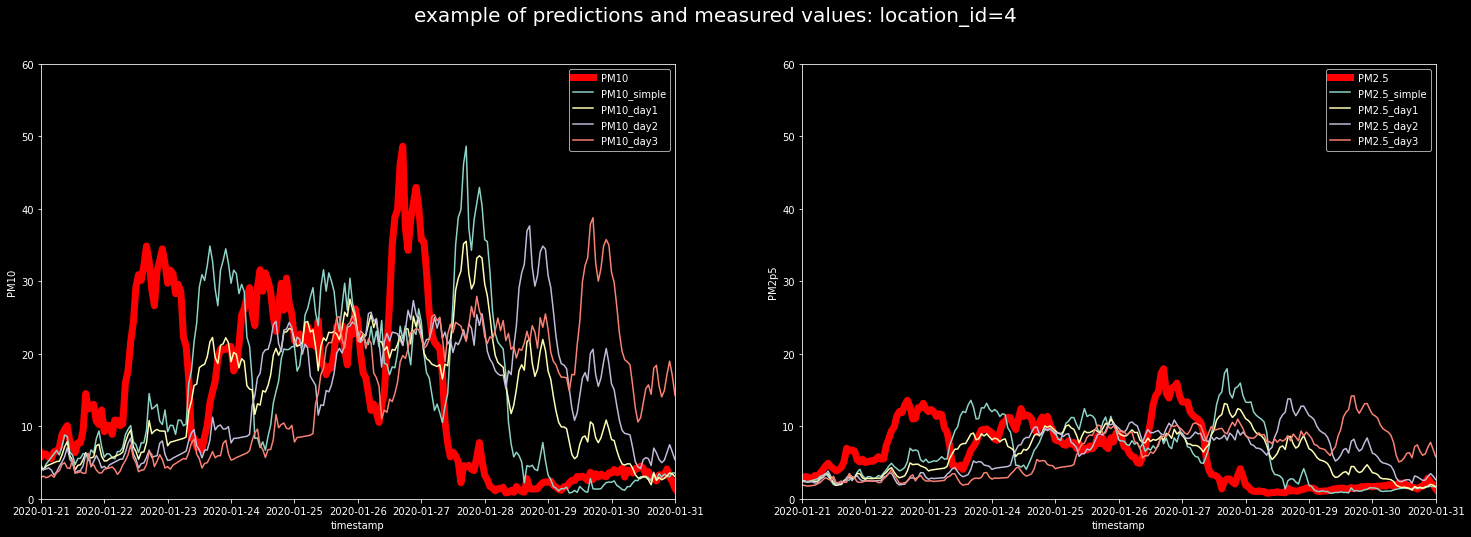

In [623]:
# plot example: prediction as function of time
location = 4 # choose location_id
plt.figure(figsize=(25, 8))
plt.suptitle(f"example of predictions and measured values: location_id={location}", fontsize=20) # title of plot

# PM10
plt.subplot(1,2,1)
sns.lineplot(data=df_base.query(f'location_id=={location}'), x='timestamp', y='PM10', color='red', linewidth=7)
sns.lineplot(data=df_base.query(f'location_id=={location}'), x='timestamp', y='PM10_simple')
sns.lineplot(data=df_base.query(f'location_id=={location}'), x='timestamp', y='PM10_day1')
sns.lineplot(data=df_base.query(f'location_id=={location}'), x='timestamp', y='PM10_day2')
sns.lineplot(data=df_base.query(f'location_id=={location}'), x='timestamp', y='PM10_day3')
plt.legend(['PM10', 'PM10_simple', 'PM10_day1', 'PM10_day2', 'PM10_day3'])
plt.xlim(pd.to_datetime('2020-01-21'),pd.to_datetime('2020-01-31'))
plt.ylim(0,60)

plt.subplot(1,2,2)
sns.lineplot(data=df_base.query(f'location_id=={location}'), x='timestamp', y='PM2p5', color='red', linewidth=7)
sns.lineplot(data=df_base.query(f'location_id=={location}'), x='timestamp', y='PM2p5_simple')
sns.lineplot(data=df_base.query(f'location_id=={location}'), x='timestamp', y='PM2p5_day1')
sns.lineplot(data=df_base.query(f'location_id=={location}'), x='timestamp', y='PM2p5_day2')
sns.lineplot(data=df_base.query(f'location_id=={location}'), x='timestamp', y='PM2p5_day3')
plt.legend(['PM2.5', 'PM2.5_simple', 'PM2.5_day1', 'PM2.5_day2', 'PM2.5_day3'])
plt.xlim(pd.to_datetime('2020-01-21'),pd.to_datetime('2020-01-31'))
plt.ylim(0,60);

(0.0, 120.0)

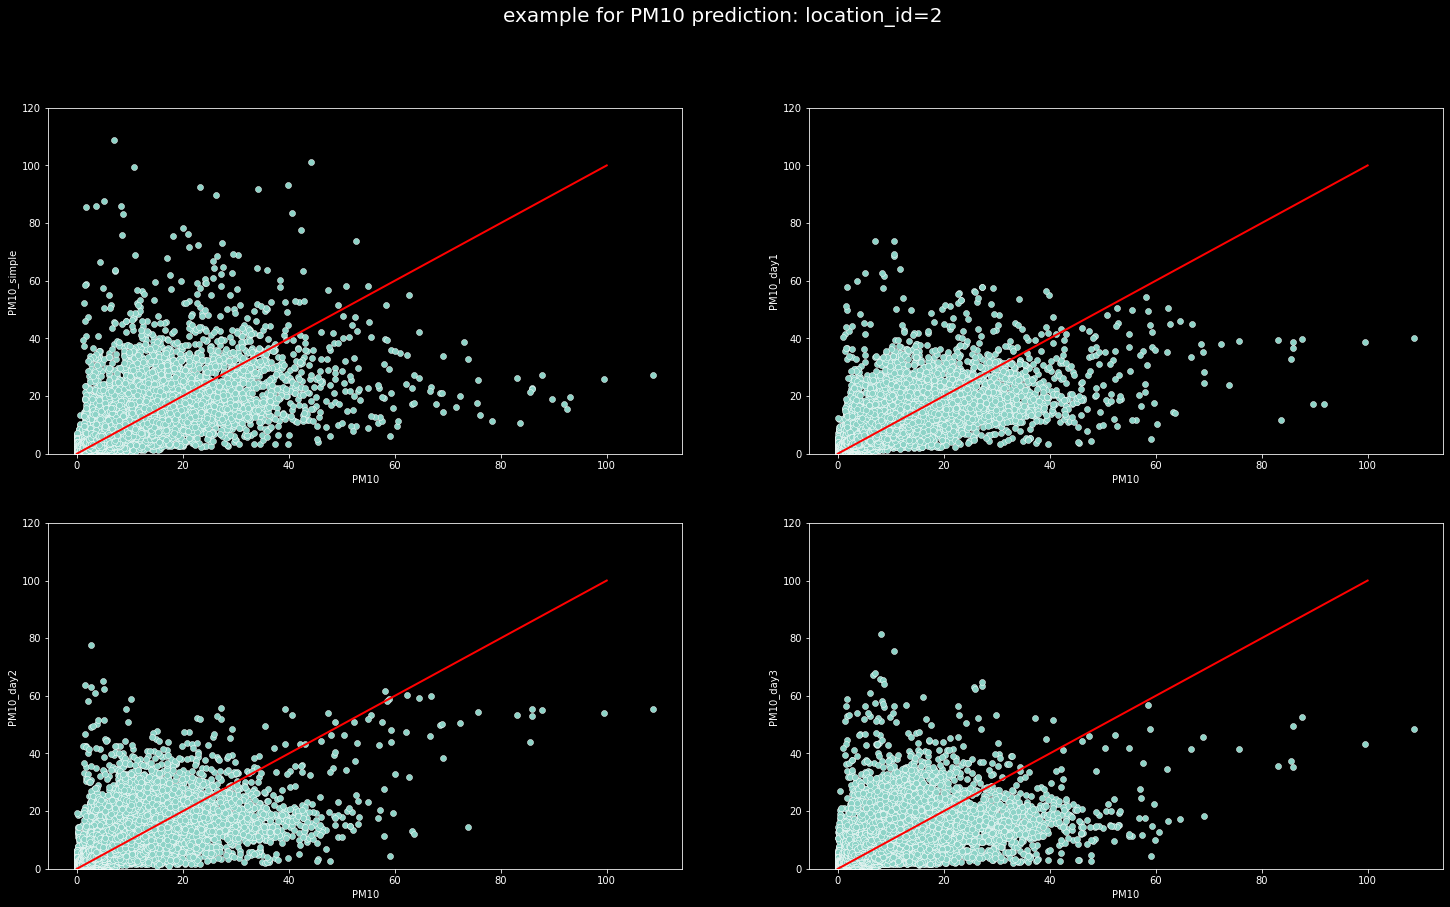

In [624]:
# plot example: prediction vs. true values
location = 2
plt.figure(figsize=(25, 14))
plt.suptitle(f"example for PM10 prediction: location_id={location}", fontsize=20) # title of plot

plt.subplot(2,2,1)
#plt.title('example: location_id=2')
sns.scatterplot(data=df_base.query(f"location_id=={location}"), x='PM10', y='PM10_simple')
plt.plot([0, 100], [0, 100], linewidth=2, color='red')
plt.ylim(0,120)

plt.subplot(2,2,2)
sns.scatterplot(data=df_base.query(f"location_id=={location}"), x='PM10', y='PM10_day1')
plt.plot([0, 100], [0, 100], linewidth=2, color='red')
plt.ylim(0,120)

plt.subplot(2,2,3)
sns.scatterplot(data=df_base.query(f"location_id=={location}"), x='PM10', y='PM10_day2')
plt.plot([0, 100], [0, 100], linewidth=2, color='red')
plt.ylim(0,120)

plt.subplot(2,2,4)
sns.scatterplot(data=df_base.query(f"location_id=={location}"), x='PM10', y='PM10_day3')
plt.plot([0, 100], [0, 100], linewidth=2, color='red')
plt.ylim(0,120)

### Root mean squared error (RMSE)

In [625]:
df_base.tail()

,location_id,timestamp,city,lat,lon,PM10,PM10_std,PM2p5,PM2p5_std,PM2p5_simple,PM10_simple,PM10_day1,PM10_day2,PM10_day3,PM2p5_day1,PM2p5_day2,PM2p5_day3
3193003,86,2021-12-31 19:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3193004,86,2021-12-31 20:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3193005,86,2021-12-31 21:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3193006,86,2021-12-31 22:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3193007,86,2021-12-31 23:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [633]:
# calculate root mean squared error (RMSE) per location, over all sensors an per city
locations = df_base.location_id.nunique() # number of locations
df_RMSE = df_base.groupby(['location_id', 'city', 'lat', 'lon']).PM10.count().reset_index().drop('PM10', axis=1) # create DataFrame of right shape

def calc_rmse(PM, base_model, df):
    """calculates RMSE for given PM type and baseline model and adds it to dataframe df_RMSE
    Args:
        PM (str): particulate matter type (PM10 or PM2.5)
        base_model (str): name of baseline model
        df (DataFrame): DataFrame with measured and predicted values
    Return: 
        rmse_all (float): RMSE for all locations, for Bremen and for Frankfurt
    """
    # RMSE for all sensors
    df_sensor = df.dropna(axis=0) # drop rows with NaN, because RMSE cannot be computed for those
    rmse_all = np.sqrt(MSE(df_sensor[PM], df_sensor[f"{PM}_{base_model}"]))
    print(f"RMSE of {PM} for all locations:", round(rmse_all,2), "µg/m3")

    # RMSE for Bremen
    df_Bremen = df_sensor[df_sensor['city'] == 'Bremen']
    rmse_Bremen = np.sqrt(MSE(df_Bremen[PM], df_Bremen[f"{PM}_{base_model}"]))

    # RMSE for Frankfurt
    df_Frankfurt = df_sensor[df_sensor['city'] == 'Frankfurt']
    rmse_Frankfurt = np.sqrt(MSE(df_Frankfurt[PM], df_Frankfurt[f"{PM}_{base_model}"]))

    # RMSE per location
    for i in range(1,locations+1):
        df_sensor = df[df['location_id']==i].dropna(axis=0) # drop rows with NaN, because RMSE cannot be computed for those
        if df_sensor.shape[0] != 0:     # check that rows for this location remain
            rmse = np.sqrt(MSE(df_sensor[f"{PM}"], df_sensor[f"{PM}_{base_model}"]))
            df_RMSE.loc[i-1,f"{PM}_{base_model}"] = rmse
    return rmse_all, rmse_Bremen, rmse_Frankfurt

RMSE of PM10 for all locations: 14.72 µg/m3
RMSE of PM2p5 for all locations: 7.57 µg/m3
RMSE of PM10 for all locations: 13.89 µg/m3
RMSE of PM2p5 for all locations: 7.11 µg/m3
RMSE of PM10 for all locations: 12.49 µg/m3
RMSE of PM2p5 for all locations: 6.33 µg/m3
RMSE of PM10 for all locations: 13.88 µg/m3
RMSE of PM2p5 for all locations: 6.95 µg/m3


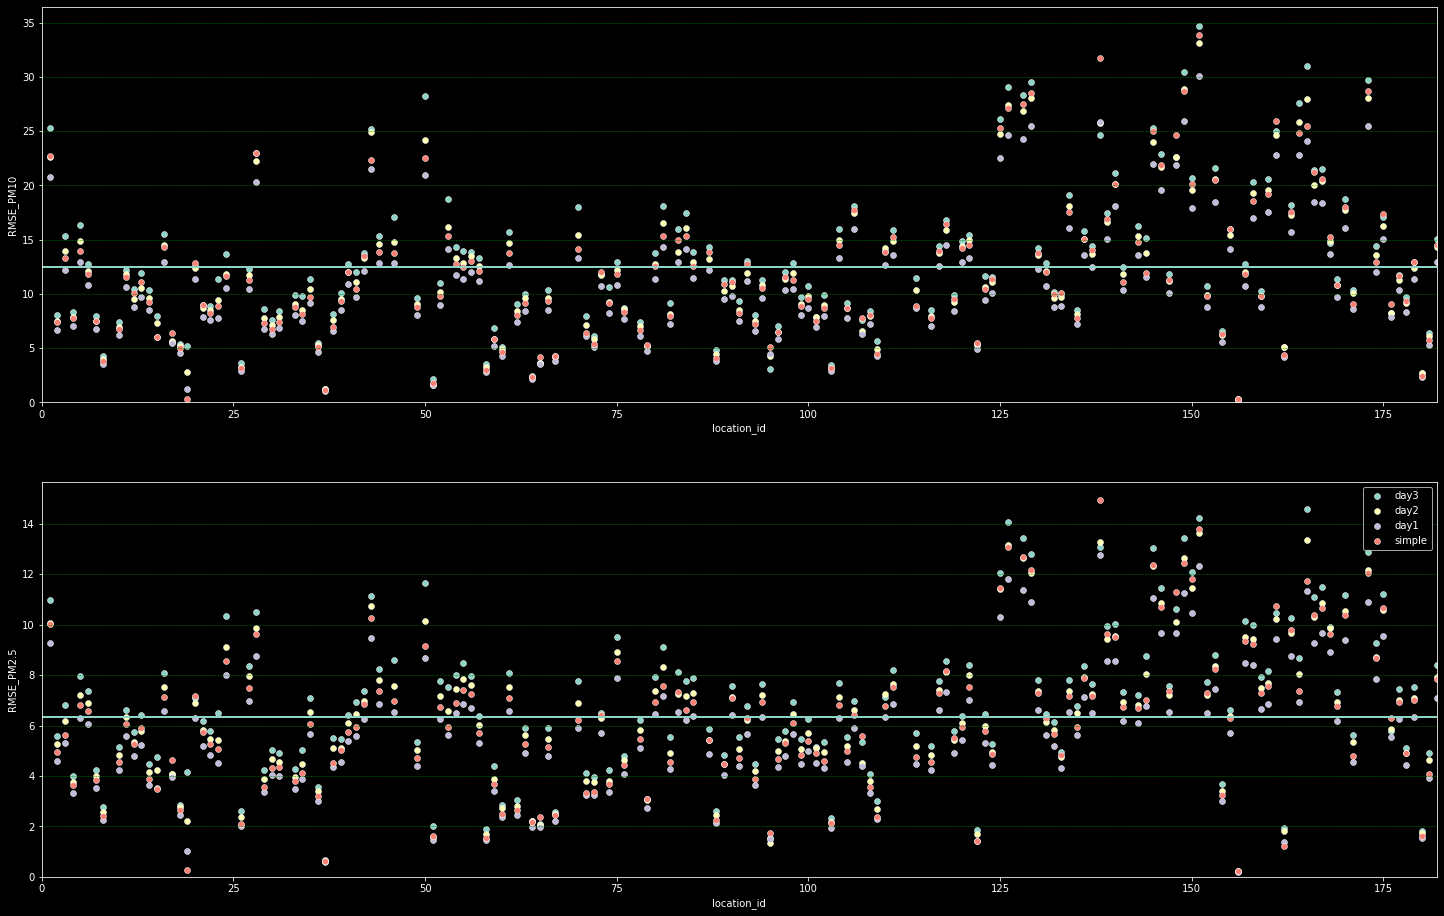

In [634]:
# save RMSE for both models for each location, for all data points, Bremen and Frankfurt, respectively and print RMSE for both models per location
base_line_models = ['day3', 'day2', 'day1', 'simple']
plt.figure(figsize=(25, 16))
rmse_all = dict()
rmse_Bremen = dict()
rmse_Frankfurt = dict()
for model in base_line_models:
    rmse_all[f"{model}_PM10"], rmse_Bremen[f"{model}_PM10"], rmse_Frankfurt[f"{model}_PM10"] = calc_rmse('PM10', model, df_base)
    rmse_all[f"{model}_PM2p5"], rmse_Bremen[f"{model}_PM2p5"], rmse_Frankfurt[f"{model}_PM2p5"] = calc_rmse('PM2p5', model, df_base)
    #df_RMSE.plot(kind='scatter', x='location_id', y=f"PM10_{model}")
    plt.subplot(2,1,1)
    sns.scatterplot(data=df_RMSE, x='location_id', y=f"PM10_{model}")
    plt.subplot(2,1,2)
    sns.scatterplot(data=df_RMSE, x='location_id', y=f"PM2p5_{model}")

plt.subplot(2,1,1)
plt.plot([0, locations], [rmse_all['day1_PM10'], rmse_all['day1_PM10']], linewidth=2)
plt.xlim(0,locations)
plt.ylabel('RMSE_PM10')
plt.grid(axis='y', color = 'green', linestyle = '--', linewidth = 0.5)
plt.ylim(0)

plt.subplot(2,1,2)
plt.plot([0, locations], [rmse_all['day1_PM2p5'], rmse_all['day1_PM2p5']], linewidth=2)
plt.legend(base_line_models)
plt.xlim(0,locations)
plt.ylabel('RMSE_PM2.5')
plt.grid(axis='y', color = 'green', linestyle = '--', linewidth = 0.5)
plt.ylim(0);

In [608]:
# show RMSE for all models, predicted days and sensors per city
print('Frankfurt')
display(rmse_Frankfurt)
print('Bremen')
display(rmse_Bremen)

Frankfurt


{'day3_PM10': 11.561583343778253,
 'day3_PM2p5': 6.227156217695665,
 'day2_PM10': 10.79634320265475,
 'day2_PM2p5': 5.806229936209315,
 'day1_PM10': 9.62589155126246,
 'day1_PM2p5': 5.109848562938824,
 'simple_PM10': 10.580722132485205,
 'simple_PM2p5': 5.5350453664809445}

Bremen


{'day3_PM10': 19.319267228000214,
 'day3_PM2p5': 9.603695259849415,
 'day2_PM10': 18.345705949784115,
 'day2_PM2p5': 9.073787535915045,
 'day1_PM10': 16.596151347557353,
 'day1_PM2p5': 8.13895302336586,
 'simple_PM10': 18.57225105358237,
 'simple_PM2p5': 9.027276438905158}

> The model that takes into account the weighted previous three days performs better than the simple model.
> The predictions worsen the farer they reach into the future (see day1, day2, day3).

Let's look at the RMSE for each measurement.

In [609]:
# calculate RMSE for each measurement
df_PM10_simple_rmse = df_base[['PM10', 'PM10_simple']].dropna(axis=0)       
df_PM10_simple_rmse['RMSE_PM10_simple'] = np.sqrt((df_PM10_simple_rmse['PM10'] - df_PM10_simple_rmse['PM10_simple'])**2)

df_PM10_day1_rmse = df_base[['PM10', 'PM10_day1']].dropna(axis=0)       
df_PM10_day1_rmse['RMSE_PM10_day1'] = np.sqrt((df_PM10_day1_rmse['PM10'] - df_PM10_day1_rmse['PM10_day1'])**2)

df_PM10_day2_rmse = df_base[['PM10', 'PM10_day2']].dropna(axis=0)       
df_PM10_day2_rmse['RMSE_PM10_day2'] = np.sqrt((df_PM10_day2_rmse['PM10'] - df_PM10_day2_rmse['PM10_day2'])**2)

df_PM10_day3_rmse = df_base[['PM10', 'PM10_day3']].dropna(axis=0)       
df_PM10_day3_rmse['RMSE_PM10_day3'] = np.sqrt((df_PM10_day3_rmse['PM10'] - df_PM10_day3_rmse['PM10_day3'])**2)



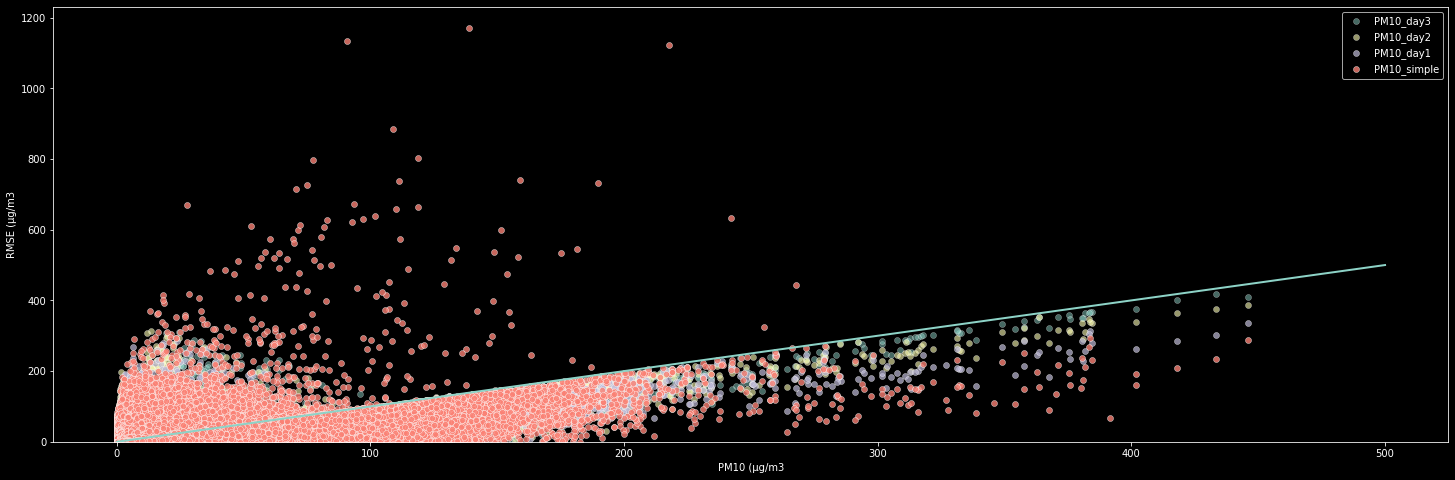

In [610]:
# plot RMSE vs. PM10
plt.figure(figsize=(25, 8))
sns.scatterplot(data=df_PM10_day3_rmse, x='PM10', y='RMSE_PM10_day3', alpha=0.5)
sns.scatterplot(data=df_PM10_day2_rmse, x='PM10', y='RMSE_PM10_day2', alpha=0.6)
sns.scatterplot(data=df_PM10_day1_rmse, x='PM10', y='RMSE_PM10_day1', alpha=0.7)
sns.scatterplot(data=df_PM10_simple_rmse, x='PM10', y='RMSE_PM10_simple', alpha=0.8)
#sns.scatterplot(data=df_PM10_1day_simple, x='PM10', y='RMSE_PM10_1day_simple', alpha=0.9)
plt.plot([0, 500], [0, 500], linewidth=2)
plt.legend(['PM10_day3', 'PM10_day2', 'PM10_day1', 'PM10_simple'])
#plt.xlim(pd.to_datetime('2020-01-21'),pd.to_datetime('2020-01-31'))
plt.ylim(0);
plt.ylabel('RMSE (µg/m3')
plt.xlabel('PM10 (µg/m3');

> The simple model works better for high PM values, but is sometime really bad for low PM10 values.

> We'll use the model taking into account the weighted last three days as baseline model.

## Predicting the test data with the baseline model

In [611]:
# load uncleaned test data
df_test = pd.read_csv("../data/processed_sensor_dwd_test.csv", index_col=0)[['timestamp', 'city', 'lat', 'lon', 'PM10', 'PM10_std', 'PM2p5', 'PM2p5_std']]

# convert timestamp to datetime
df_test.timestamp = pd.to_datetime(df_test.timestamp)

# add sensor IDs
df_location = df_test.groupby(['lat', 'lon']).count().reset_index()[['lat', 'lon']]
df_location['location_id'] = df_location.index+1
df_test = df_test.merge(df_location, on=['lat', 'lon'], how='left')

# mark test data
df_test['test'] = True

df_test.sample(10)
df_test.tail(20)
df_test.head()
#df_test.shape


,timestamp,city,lat,lon,PM10,PM10_std,PM2p5,PM2p5_std,location_id,test
0,2022-01-01 00:00:00,Frankfurt,50.042,8.436,NaN,NaN,NaN,NaN,2,True
1,2022-01-01 01:00:00,Frankfurt,50.042,8.436,NaN,NaN,NaN,NaN,2,True
2,2022-01-01 02:00:00,Frankfurt,50.042,8.436,NaN,NaN,NaN,NaN,2,True
3,2022-01-01 03:00:00,Frankfurt,50.042,8.436,NaN,NaN,NaN,NaN,2,True
4,2022-01-01 04:00:00,Frankfurt,50.042,8.436,NaN,NaN,NaN,NaN,2,True


In [612]:
# take only last 3 days of training data
df_base_train = df_base.query("timestamp > '2021-12-28 23:00:00'")[['location_id', 'timestamp', 'city', 'lat', 'lon', 'PM10', 'PM10_std', 'PM2p5', 'PM2p5_std']]
# mark train data
df_base_train['test'] = False
df_base_train.shape

(13104, 10)

In [613]:
# merge train and test
df_base_test = pd.concat([df_base_train, df_test])
df_base_test['PM10_pred'] = np.nan

df_base_test.sort_values(['timestamp', 'location_id'], inplace=True)
df_base_test.reset_index(inplace=True)
df_base_test.drop('index', axis=1, inplace=True)

df_base_test

,location_id,timestamp,city,lat,lon,PM10,PM10_std,PM2p5,PM2p5_std,test,PM10_pred
0,1,2021-12-29 00:00:00,Frankfurt,50.032000,8.784000,NaN,NaN,NaN,NaN,False,NaN
1,2,2021-12-29 00:00:00,Frankfurt,50.042000,8.436000,1.455417,0.557900,0.751667,0.170642,False,NaN
2,3,2021-12-29 00:00:00,Frankfurt,50.046000,8.852000,NaN,NaN,NaN,NaN,False,NaN
3,4,2021-12-29 00:00:00,Frankfurt,50.050000,8.690000,3.077143,1.015963,1.280000,0.204548,False,NaN
4,5,2021-12-29 00:00:00,Frankfurt,50.054000,8.790000,NaN,NaN,NaN,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...
270811,178,2022-02-28 23:00:00,Bremen,53.126000,8.760000,NaN,NaN,NaN,NaN,True,NaN
270812,179,2022-02-28 23:00:00,Bremen,53.131823,8.732302,29.000000,2.167469,14.251818,0.638940,True,NaN
270813,180,2022-02-28 23:00:00,Bremen,53.132000,8.708000,5.765263,0.447950,5.185789,0.387317,True,NaN
270814,181,2022-02-28 23:00:00,Bremen,53.132000,8.732000,NaN,NaN,NaN,NaN,True,NaN


In [614]:
# set weights
w1, w2, w3 = 3, 2, 1
day1 = df_base_test['timestamp'].dt.date.min() + pd.Timedelta(days=3) # first test date
last_day = df_base_test['timestamp'].dt.date.max() # last test date
# days to be predicted
days = (last_day - day1).days

# calculate predicted values for PM10 as mean of previous three days with weights w1-w3 for day 1
end = df_base_test.query(f"'{day1} 23:00:00' == timestamp").index.max()
df_base_test.loc[0:end,'PM10_pred_1'] = (df_base_test.loc[0:end].groupby(['location_id'])['PM10'].shift(24) * w1 + df_base_test.loc[0:end].groupby(['location_id'])['PM10'].shift(48) * w2 + df_base_test.loc[0:end].groupby(['location_id'])['PM10'].shift(72) * w3) / (w1+w2+w3) 
# day2
end = df_base_test.query(f"'{day1 + pd.Timedelta(hours=24)} 23:00:00' == timestamp").index.max()
df_base_test.loc[0:end,'PM10_pred_2'] = (df_base_test.loc[0:end].groupby(['location_id'])['PM10_pred_1'].shift(24) * w1 + df_base_test.loc[0:end].groupby(['location_id'])['PM10'].shift(48) * w2 + df_base_test.loc[0:end].groupby(['location_id'])['PM10'].shift(72) * w3) / (w1+w2+w3) 
# day3
end = df_base_test.query(f"'{day1 + pd.Timedelta(hours=48)} 23:00:00' == timestamp").index.max()
df_base_test.loc[0:end,'PM10_pred_3'] = (df_base_test.loc[0:end].groupby(['location_id'])['PM10_pred_2'].shift(24) * w1 + df_base_test.loc[0:end].groupby(['location_id'])['PM10_pred_1'].shift(48) * w2 + df_base_test.loc[0:end].groupby(['location_id'])['PM10'].shift(72) * w3) / (w1+w2+w3) 

# day4 to end of prediction
for day in range (4, days+1):
    end = df_base_test.query(f"'{day1 + pd.Timedelta(hours=(day-1)*24)} 23:00:00' == timestamp").index.max()
    df_base_test.loc[0:end,f'PM10_pred_{day}'] = (df_base_test.loc[0:end].groupby(['location_id'])[f'PM10_pred_{day-1}'].shift(24) * w1 + df_base_test.loc[0:end].groupby(['location_id'])[f'PM10_pred_{day-2}'].shift(48) * w2 + df_base_test.loc[0:end].groupby(['location_id'])[f'PM10_pred_{day-3}'].shift(72) * w3) / (w1+w2+w3) 

# coalesce predicted values in one column
for day in range(1, days+1):
    df_base_test['PM10_pred'] = df_base_test['PM10_pred'].combine_first(df_base_test[f'PM10_pred_{day}'])
    df_base_test.drop(f'PM10_pred_{day}', axis=1, inplace=True)


In [615]:
# show results at given location and for fixed hour
df_base_test.query("location_id==4").loc[4050::24].head(10)

,location_id,timestamp,city,lat,lon,PM10,PM10_std,PM2p5,PM2p5_std,test,PM10_pred
4189,4,2021-12-29 23:00:00,Frankfurt,50.05,8.69,16.582381,2.435767,10.200952,1.276922,False,NaN
8557,4,2021-12-30 23:00:00,Frankfurt,50.05,8.69,5.034091,1.213059,2.777273,0.211146,False,NaN
12925,4,2021-12-31 23:00:00,Frankfurt,50.05,8.69,17.916667,7.272228,12.376190,4.659368,False,NaN
17293,4,2022-01-01 23:00:00,Frankfurt,50.05,8.69,15.356190,2.132160,9.295238,0.484186,True,13.400094
21661,4,2022-01-02 23:00:00,Frankfurt,50.05,8.69,6.285556,1.648230,2.444444,0.297998,True,13.511284
26029,4,2022-01-03 23:00:00,Frankfurt,50.05,8.69,9.872381,1.956282,5.197619,1.091462,True,14.208451
30397,4,2022-01-04 23:00:00,Frankfurt,50.05,8.69,9.690000,1.561230,7.204091,0.696499,True,13.841336
34765,4,2022-01-05 23:00:00,Frankfurt,50.05,8.69,7.733636,1.714639,3.218636,0.245421,True,13.908699
39133,4,2022-01-06 23:00:00,Frankfurt,50.05,8.69,17.599412,2.086320,7.607059,0.382766,True,13.936203
43501,4,2022-01-07 23:00:00,Frankfurt,50.05,8.69,12.010455,2.629370,7.977273,1.232211,True,13.911224


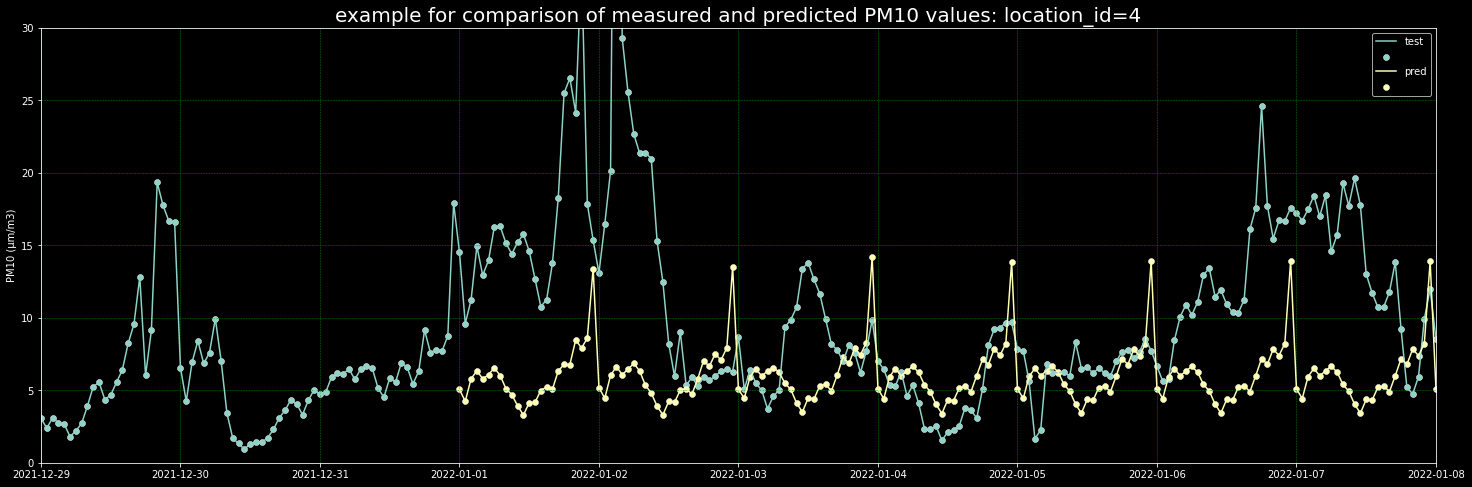

In [616]:
# plot example: prediction vs. true values
location = 4
plt.figure(figsize=(25, 8))
plt.title(f"example for comparison of measured and predicted PM10 values: location_id={location}", fontsize=20) # title of plot

sns.lineplot(data=df_base_test.query(f"location_id=={location}"), x='timestamp', y='PM10', legend='auto')
sns.scatterplot(data=df_base_test.query(f"location_id=={location}"), x='timestamp', y='PM10')
sns.lineplot(data=df_base_test.query(f"location_id=={location}"), x='timestamp', y='PM10_pred', legend='auto')
sns.scatterplot(data=df_base_test.query(f"location_id=={location}"), x='timestamp', y='PM10_pred')
plt.xlim(pd.to_datetime('2021-12-29'),pd.to_datetime('2022-01-08'))
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.ylim(0,30)
plt.xlabel('')
plt.ylabel('PM10 (µm/m3)')
plt.legend(['test', '','pred', ''])


Text(0, 0.5, 'PM10_pred (µm/m3)')

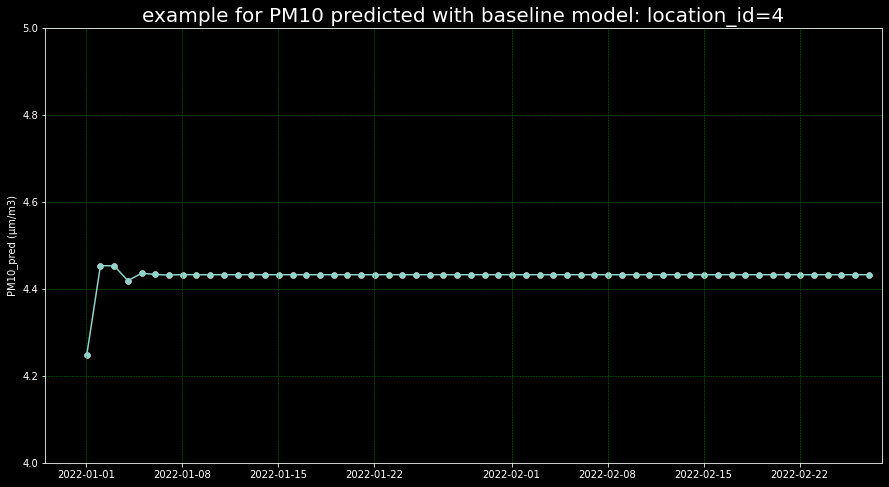

In [617]:
# plot example: prediction vs. true values
location = 4
plt.figure(figsize=(15, 8))
plt.title(f"example for PM10 predicted with baseline model: location_id={location}", fontsize=20) # title of plot

sns.lineplot(data=df_base_test.query(f"location_id=={location}")[1::24], x='timestamp', y='PM10_pred', legend='auto')
sns.scatterplot(data=df_base_test.query(f"location_id=={location}")[1::24], x='timestamp', y='PM10_pred')
plt.xlim(pd.to_datetime('2021-12-29'),pd.to_datetime('2022-02-28'))
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.ylim(4,5)
plt.xlabel('')
plt.ylabel('PM10_pred (µm/m3)');

> prediction flattens quite fast

### Root mean squared error (RMSE)

In [789]:
# calculate root mean squared error (RMSE) per location, over all sensors an per city
# add day number to dataframe
df_base_test['date'] = (df_base_test['timestamp'].dt.date)
df_base_test['day'] = df_base_test['date'].apply(lambda x: (x - day1 + pd.Timedelta(days=1)).days)

# create DataFrame of right shape
df_RMSE_base = df_base_test.groupby(['date', 'day']).PM10.count().reset_index().drop('PM10', axis=1) 

def calc_rmse_base(PM, df):
    """calculates RMSE and add it to dataframe df_RMSE_base
    Args:
        PM (str): particulate matter type (PM10 or PM2.5)
                df (DataFrame): DataFrame with measured and predicted values
    Return: 
        rmse_all (float): RMSE for all locations, for Bremen and for Frankfurt
    """
   
    # RMSE for all days
    df_day = df.dropna(axis=0) # drop rows with NaN, because RMSE cannot be computed for those
    rmse_all = np.sqrt(MSE(df_day[PM], df_day[f"{PM}_pred"]))
    print(f"RMSE of {PM} for all days:", round(rmse_all,2), "µg/m3")

    # RMSE for Bremen
    df_Bremen = df_day[df_day['city'] == 'Bremen']
    rmse_Bremen = np.sqrt(MSE(df_Bremen[PM], df_Bremen[f"{PM}_pred"]))

    # RMSE for Frankfurt
    df_Frankfurt = df_day[df_day['city'] == 'Frankfurt']
    rmse_Frankfurt = np.sqrt(MSE(df_Frankfurt[PM], df_Frankfurt[f"{PM}_pred"]))

    # RMSE per location
    for day in range(1,days+1):
        df_day = df[df['day'] == day].dropna(axis=0) # drop rows with NaN, because RMSE cannot be computed for those
        if df_day.shape[0] != 0:     # check that rows for this location remain
            rmse = np.sqrt(MSE(df_day[f"{PM}"], df_day[f"{PM}_pred"]))
            df_RMSE_base.loc[day+2,f"RMSE_{PM}_pred"] = rmse
    return rmse_all, rmse_Bremen, rmse_Frankfurt

RMSE of PM10 for all days: 16.79 µg/m3


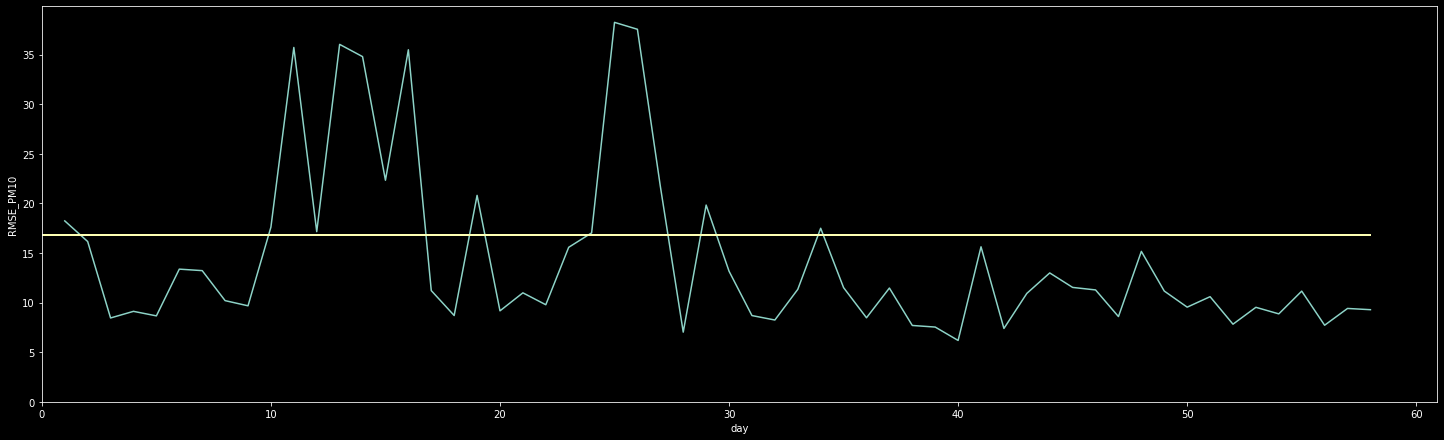

In [805]:
# calculate RMSE for both models for each location, for all data points, Bremen and Frankfurt, respectively and print RMSE for both models per location
rmse_all = dict()
rmse_Bremen = dict()
rmse_Frankfurt = dict()

plt.figure(figsize=(25, 16))

rmse_all["PM10_pred"], rmse_Bremen["PM10_pred"], rmse_Frankfurt["PM10_pred"] = calc_rmse_base('PM10',  df_base_test)
#rmse_all["PM2p5_pred"], rmse_Bremen[f"PM2p5"], rmse_Frankfurt[f"PM2p5"] = calc_rmse_base('PM2p5', df_base_test)
plt.subplot(2,1,1)
sns.lineplot(data=df_RMSE_base, x='day', y="RMSE_PM10_pred")
plt.plot([0, days], [rmse_all['PM10_pred'], rmse_all['PM10_pred']], linewidth=2)
plt.ylim(0)
plt.xlim(0)
plt.ylabel('RMSE_PM10');